# How Close is the 2020 U.S. Presidential Election Race?

We see the latest poll updates and understand polling averages, but 2016 jaded many of us in terms of trusting poll numbers. We can use weighted poll averages based upon the quality of the poll conducted and monte carlo simulations to provide candidate probabilities for each state.

![election](https://raw.githubusercontent.com/ahoaglandnu/election2020/master/graphics/election2020.png)

In [1]:
%matplotlib inline
import numpy as np, pandas as pd, plotly.graph_objects as go
import random
import datetime
from collections import Counter
import warnings 
import matplotlib.pyplot as plt
random.seed(2020)
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

### Polls Only Probabilities

If we look at all the states where a candidate has at least a 50% probability without any undecided voters, we get our first benchmark for the state of the race.

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/ahoaglandnu/election2020/master/results/results_20200811.csv')
print('Biden electoral college votes with at least a 50% probability:', np.sum(df['ec'][df['Biden_probability'] >= .5]))
print()
print('Trump electoral college votes with at least a 50% probability:', np.sum(df['ec'][df['Trump_probability'] >= .5]))

Biden electoral college votes with at least a 50% probability: 262

Trump electoral college votes with at least a 50% probability: 111


You may have noticed that the total does not add up to 538, the total votes in the Electoral College. That is because we are only looking at states where one candidate has at least a 50% majority.

### But we have to consider what happened in 2016

Undecided voters swayed election results in states where one candidate did not have a 50% or higher majority. When we add ALL undecided votes to Trump, we get new probabilities for each state. 

In [3]:
print('Biden electoral college votes if ALL undecided voters go for Trump:',np.sum(df['ec'][df['biden_alt_prob'] >= .5]))
print()
print('Trump electoral college votes if ALL undecided voters go for Trump:',np.sum(df['ec'][df['trump_alt_prob'] >= .5]))

Biden electoral college votes if ALL undecided voters go for Trump: 258

Trump electoral college votes if ALL undecided voters go for Trump: 280


Polls and simple corrections to polls give us two different outcomes. This is our first clear indication that the race is far closer and more complex than it may initially appear.

# How the undecided vote can determine the winner

On election day, the votes for each candidate will add up to 100%. When polls do not have a candidate with a majority of the votes, then the candidate "winning" the race is not necessarily in the lead.

We can illustrate this scenario by examining a simple pie chart.

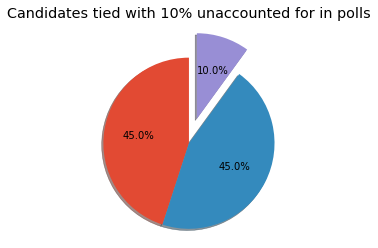

In [5]:
sizes = [45, 45, 10]
explode = (0, 0, 0.3)  
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.title("Candidates tied with 10% unaccounted for in polls")
plt.show()

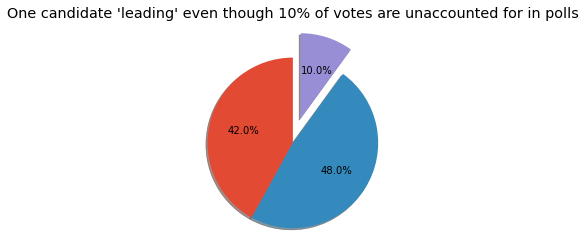

In [6]:
sizes = [42, 48, 10]
explode = (0, 0, 0.3)  
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  
plt.title("One candidate 'leading' even though 10% of votes are unaccounted for in polls")
plt.show()

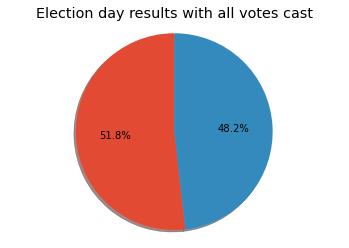

In [7]:
sizes = [51.8, 48.2]  
fig1, ax1 = plt.subplots()
ax1.pie(sizes, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.title('Election day results with all votes cast')
plt.show()

On election day, the majority of undecided voters in polling voted for one candidate.

This is the outcome we saw in 2016 in several states that ultimately determined the winner of the election.

# Randomly Distribute the Undecided Vote

The most mathematically unbiased method is to randomly distribute undecided voters to each candidate.

A random number generator will pick a value between .01 and .99. 

One candidate will receive that percentage of the undecided votes for the state; the other candidate the remaining undecided votes.

For the polling results, we will use normal distribution to randomly choose the number of votes cast for each candidate using the weighted polling as the average assuming a 3 percent margin of error.

The undecided votes will then be added to the the polling results and the candidate with the highest number of votes will win that state.

We will do the above process for each state 20,000 times. The number of times a candidate wins each state divided by the number of simulations (20,000) will be our probability the candidate will win the state.

In [8]:
def moe(x, y, n):
    min_x = x - n
    max_x = x + n
    std_x = (max_x - min_x) / 4
    min_y = y - n
    max_y = y + n
    std_y = (max_y - min_y) / 4
    return round(random.gauss(x, std_x),1), round(random.gauss(y, std_y),1)
def distro_sim(x, y, n=3, num_sims=20000):
    u = 100 - (x + y)
    x_wins = 0
    y_wins = 0
    for i in range(num_sims):
        rand = np.random.uniform(low=0.01,high=.99)
        x1 = x + (u * rand)
        y1 = y + (u * (1 - rand))
        x1, y1 = moe(x1, y1, n)
        if x1 > y1:
            x_wins += 1
        else:
            y_wins += 1
    return x_wins/num_sims, y_wins/num_sims 

In [9]:
b = df['Biden_avg'].values
t = df['Trump_avg'].values
rand_prob = []
for x, y in zip(b,t):
    rp = distro_sim(x,y)
    rand_prob.append(rp)
df['biden_rand_prob'] = [i[0] for i in rand_prob]
df['trump_rand_prob'] = [i[1] for i in rand_prob]
df.loc[(df['cook'] == 'Solid Dem') & (df['Biden_avg'].isnull()),'biden_rand_prob'] = 1.0
df.loc[(df['cook'] == 'Solid Dem') & (df['Biden_avg'].isnull()),'trump_rand_prob'] = 0.0
df.loc[(df['cook'] == 'Solid Rep') & (df['Trump_avg'].isnull()),'biden_rand_prob'] = 0.0
df.loc[(df['cook'] == 'Solid Rep') & (df['Trump_avg'].isnull()),'trump_rand_prob'] = 1.0
print('Biden electoral college votes with randomly distributed undecided votes:', np.sum(df['ec'][df['biden_rand_prob'] >= .5]))
print()
print('Trump electoral college votes with randomly distributed undecided votes:',np.sum(df['ec'][df['trump_rand_prob'] >= .5]))

Biden electoral college votes with randomly distributed undecided votes: 352

Trump electoral college votes with randomly distributed undecided votes: 186


### That looks like a landslide. Is anyone else getting that result?

Yes. At the time of creation, [The Economist](https://projects.economist.com/us-2020-forecast/president) had the same forecast  
![economist](https://raw.githubusercontent.com/ahoaglandnu/election2020/master/graphics/economist0811.png)

### "But we have to consider what happened in 2016"

I hear this all the time and I agree. 

Even if forecast models are constructed in a manner that worked for other elections in the past, there is a prevailing sense that the 2016 polling errors can or will occur again in 2020.

To answer this concern, we will identify the 2020 battleground states and recreate the 2016 polling error.

# Battleground States According to the Cook Political Report

States labeled as **toss up** and **leaning** will be considered battleground states.   

Note the poll-based probabilities below. We see divergences between the probabilities and qualitative assessments.

In [10]:
df[df['cook'].str.startswith('Lean R', na=False)][['State','cook','biden_rand_prob','trump_rand_prob','Biden_avg','Trump_avg']]

State      cook  biden_rand_prob  trump_rand_prob  Biden_avg  Trump_avg
11   iowa  Lean Rep          0.41350          0.58650       44.5       46.0
27   ohio  Lean Rep          0.77495          0.22505       48.4       44.4
31  texas  Lean Rep          0.27890          0.72110       43.7       47.5

In [11]:
df[df['cook'].str.startswith('Lean D', na=False)][['State','cook','biden_rand_prob','trump_rand_prob','Biden_avg','Trump_avg']]

State      cook  biden_rand_prob  trump_rand_prob  Biden_avg  \
16       michigan  Lean Dem          0.97465          0.02535       50.4   
17      minnesota  Lean Dem          0.89155          0.10845       49.3   
22  new hampshire  Lean Dem          0.96130          0.03870       50.3   
28   pennsylvania  Lean Dem          0.79520          0.20480       48.5   
35      wisconsin  Lean Dem          0.86990          0.13010       48.8   

    Trump_avg  
16       40.4  
17       43.1  
22       42.7  
28       44.0  
35       42.0

In [12]:
df[df['cook'].str.startswith('Toss', na=False)][['State','cook','biden_rand_prob','trump_rand_prob','Biden_avg','Trump_avg']]

State     cook  biden_rand_prob  trump_rand_prob  Biden_avg  \
2          arizona  Toss Up          0.54735          0.45265       46.4   
8          florida  Toss Up          0.95095          0.04905       50.7   
9          georgia  Toss Up          0.21555          0.78445       44.6   
26  north carolina  Toss Up          0.66760          0.33240       47.7   

    Trump_avg  
2        45.6  
8        46.0  
9        48.5  
26       45.3

### Factoring in what we witnessed for the 2016 election

States that were **Lean Dem** and **Toss Up** in 2016 had undecided voters overwhelming vote for Trump.

To replicate this, we will use our **all undecided votes for Trump** probabilities for these states **unless** Biden is polling over 50% in a Lean Dem state.

In [13]:
def qual_correction (row):
    if row['cook'] == "Lean Dem" and row['Biden_avg'] < 50:
        return row['trump_alt_prob']
    if row['cook'] == "Lean Rep" :
        return row['trump_alt_prob']
    if row['cook'] == 'Toss Up' :
        return row['trump_alt_prob']
    else:
        return row['trump_rand_prob']
def qual_correction_opp (row):
    if row['cook'] == "Lean Dem" and row['Biden_avg'] < 50:
        return row['biden_alt_prob']
    if row['cook'] == "Lean Rep" :
        return row['biden_alt_prob']
    if row['cook'] == 'Toss Up' :
        return row['biden_alt_prob']
    else:
        return row['biden_rand_prob']

In [14]:
df['biden_qual_prob'] = df['biden_rand_prob']
df['trump_qual_prob'] = df['trump_rand_prob']
df['trump_qual_prob'] = df.apply (lambda row: qual_correction(row), axis=1)
df['biden_qual_prob'] = df.apply (lambda row: qual_correction_opp(row), axis=1)

#### The adjusted poll-based probabilities align with some qualitative assessments while making other states more competitive. 

In [15]:
df[df['cook'].str.startswith('Lean R', na=False)][['State','cook','biden_qual_prob','trump_qual_prob','Biden_avg','Trump_avg']]

State      cook  biden_qual_prob  trump_qual_prob  Biden_avg  Trump_avg
11   iowa  Lean Rep          0.00000          1.00000       44.5       46.0
27   ohio  Lean Rep          0.04185          0.95815       48.4       44.4
31  texas  Lean Rep          0.00000          1.00000       43.7       47.5

In [16]:
df[df['cook'].str.startswith('Lean D', na=False)][['State','cook','biden_qual_prob','trump_qual_prob','Biden_avg','Trump_avg']]

State      cook  biden_qual_prob  trump_qual_prob  Biden_avg  \
16       michigan  Lean Dem          0.97465          0.02535       50.4   
17      minnesota  Lean Dem          0.17085          0.82915       49.3   
22  new hampshire  Lean Dem          0.96130          0.03870       50.3   
28   pennsylvania  Lean Dem          0.05240          0.94760       48.5   
35      wisconsin  Lean Dem          0.08605          0.91395       48.8   

    Trump_avg  
16       40.4  
17       43.1  
22       42.7  
28       44.0  
35       42.0

In [17]:
df[df['cook'].str.startswith('Toss', na=False)][['State','cook','biden_qual_prob','trump_qual_prob','Biden_avg','Trump_avg']]

State     cook  biden_qual_prob  trump_qual_prob  Biden_avg  \
2          arizona  Toss Up          0.00015          0.99985       46.4   
8          florida  Toss Up          0.59325          0.40675       50.7   
9          georgia  Toss Up          0.00000          1.00000       44.6   
26  north carolina  Toss Up          0.00815          0.99185       47.7   

    Trump_avg  
2        45.6  
8        46.0  
9        48.5  
26       45.3

### If all undecided voters go for Trump in battleground states

In [18]:
df2 = df[['State','code','ec','cook','Biden_avg','Trump_avg','biden_qual_prob','trump_qual_prob']]
for col in df2.columns:
    df2[col] = df2[col].astype(str)
df2['text'] = df2['State'] + '<br>' + \
'Electoral College Votes '+ df2['ec'] +  '<br>' + \
'Cook Political Report: ' + df2['cook'] + '<br>' + \
'Biden ' + df2['Biden_avg'] + ' Trump ' + df2['Trump_avg'] + '<br>'\
'Biden probability ' + df2['biden_qual_prob'] + '<br>'\
'Trump probability ' + df2['trump_qual_prob']

In [19]:
fig = go.Figure(data=go.Choropleth(
    locations=df2['code'],
    z=df2['biden_qual_prob'].astype(float),
    locationmode='USA-states',
    colorscale='RdBu',
    autocolorscale=False,
    text=df2['text'], 
    marker_line_color='white',
    colorbar_title="Biden Probability"
))
fig.update_layout(
    title_text='State probabilities with battleground undecided voters favoring Trump',
    geo = dict(
        scope='usa',
        projection=go.layout.geo.Projection(type = 'albers usa'),
        showlakes=False),
)

fig.show()

### State probabilities do not necessarily mean probable Electoral College outcome

In [20]:
print('Biden electoral college votes if ALL undecided voters in battleground states go for Trump:', np.sum(df['ec'][df['biden_qual_prob'] >= .5]))
print()
print('Trump electoral college votes if ALL undecided voters in battleground states go for Trump:', np.sum(df['ec'][df['trump_qual_prob'] >= .5]))

Biden electoral college votes if ALL undecided voters in battleground states go for Trump: 268

Trump electoral college votes if ALL undecided voters in battleground states go for Trump: 270


We see that recreating the 2016 polling error in battleground states brings the race far closer.

It should be kept in mind that the numbers below are simply a sum of states where a candidate has at least a 50% chance of winning that state. If we think about it, a 50% probability is the same as a coin toss.

We are left questioning how many different combinations of outcomes for each state produce a different winner.

# An Electoral College Monte Carlo Simulation

Since we have probabilities for each state, a random number generator will determine if the candidate won that state. 


To replicate ideological voter trends, the **Lean Rep** block of states will have their own random number for each simulation round.  

The **Lean Dem** block of states will also have their own random number for each simulation round.   

Each **Toss Up** state will have its own unique random number for each simulation round.    

In [21]:
lean_r = list(df[df['cook'].str.startswith('Lean R', na=False)]['State'])
lean_d = list(df[df['cook'].str.startswith('Lean D', na=False)]['State'])
tossup = list(df[df['cook'].str.startswith('Toss', na=False)]['State'])

In [22]:
def electoral_college(ec, cand, state, sims=20000):
    cand_wins = 0
    cand_ec_total = []
    cand_states = []
    for i in range(sims):
        cand_ec = 0
        cand_state = []
        sim_election = np.random.uniform(low=0.05)
        lean_r_sim = np.random.uniform()
        lean_d_sim = np.random.uniform()
        for x, y, z in zip(cand, states, ec):
            if y in lean_r:
                sim_election = lean_r_sim
            elif y in lean_d:
                sim_election = lean_d_sim
            elif y in tossup:
                sim_election = np.random.uniform()
            if x > sim_election:
                cand_ec += z
                cand_state.append(y)
        cand_ec_total.append(cand_ec)
        cand_states.append(cand_state)
        if cand_ec > 269:
            cand_wins += 1
    return cand_wins, cand_ec_total, cand_states

In [23]:
print("Monte Carlo Simulation of Electoral College Results")
print()
sims = 20000
ec = list(df.ec.values)
states = list(df.State.values)
cand_1 = list(df['biden_qual_prob'].values)
cand_1_wins, cand_1_ec_totals, cand_1_states = electoral_college(ec, cand_1, states, sims=sims)
print('Biden Win Percentage:', (cand_1_wins/sims)*100)
print('Biden Avg EC Votes:', sum(cand_1_ec_totals) / len(cand_1_ec_totals))
print()
cand_2 = list(df['trump_qual_prob'].values)  
cand_2_wins, cand_2_ec_totals, cand_2_states = electoral_college(ec, cand_2, states, sims=sims)
print('Trump Win Percentage:', (cand_2_wins/sims)*100)
print('Trump Avg EC Votes:', sum(cand_2_ec_totals) / len(cand_2_ec_totals))

Monte Carlo Simulation of Electoral College Results

Biden Win Percentage: 36.335
Biden Avg EC Votes: 263.51915

Trump Win Percentage: 61.925
Trump Avg EC Votes: 274.3046


### The race is very close when factoring in the potential for 2016 polling errors in critical battleground states

In [24]:
print('Given the state probabilities under a polling error scenario:')
print("{:0.2f}".format((cand_1_wins/sims)*100),'% of the potential state outcomes result in a victory for Biden.')
print("{:0.2f}".format((cand_2_wins/sims)*100),'% of the potential state outcomes result in a victory for Trump.')
print()
print('The most common simulation outcome was',
      Counter(cand_1_ec_totals).most_common(n=1)[:1][0][0], 'for Biden and',
      Counter(cand_2_ec_totals).most_common(n=1)[:1][0][0], 'for Trump.')

Given the state probabilities under a polling error scenario:
36.34 % of the potential state outcomes result in a victory for Biden.
61.92 % of the potential state outcomes result in a victory for Trump.

The most common simulation outcome was 268 for Biden and 270 for Trump.


A graphic of each simulated election results is below.

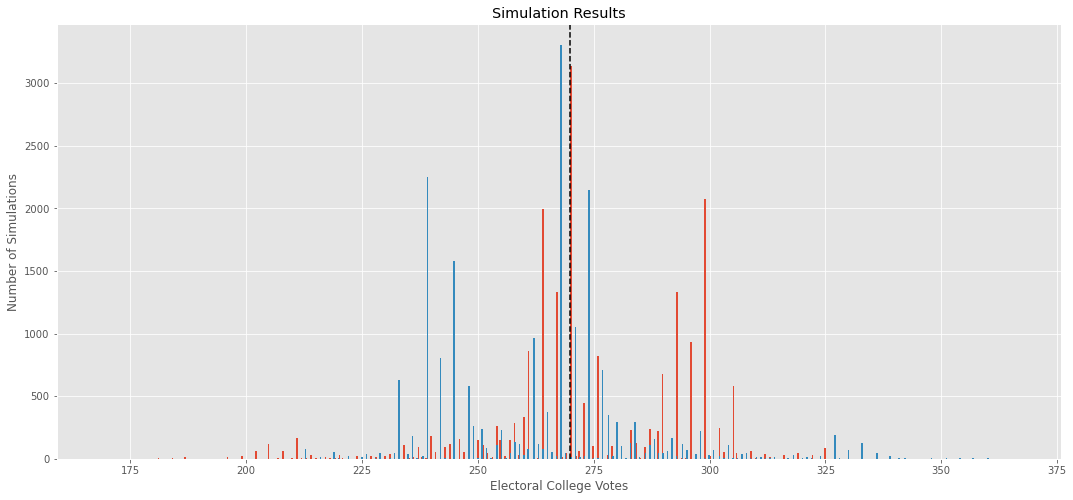

In [25]:
plt.figure(figsize=(18,8))
plt.hist(cand_2_ec_totals,500)
plt.hist(cand_1_ec_totals,500)
plt.axvline(x=270, color='k', linestyle='dashed')
plt.xlabel('Electoral College Votes')
plt.ylabel('Number of Simulations')
plt.title('Simulation Results')
plt.show()

# Conclusion

A variety of simulated outcomes are best suited to provide insights into the status of the Presidential Election race. We simply cannot state definitively if certain states will have a similar polling error as they did in 2016. What we can say is that is that we can have far more confidence in those weighted polling averages when a candidate is above 50% than when both candidates are below 50%.

When we take the most unbiased method of distributing the undecided vote, we have a very clear winner. Yet, when we anticipate an undecided vote swing to one candidate as we did in 2016, we have a race that is closer than some covering the election portray it to be. 

The ability to answer "what if" scenarios without defending a specific methodology ensures the goal of the forecast is to inform the public as best as possible. While it may be a challenge to explain how close the race is, now we can at least explain why.